# Deep Learning - Driver Type Classification (Supervised)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import time
import tensorflow as tf
import random
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from keras.layers import Conv1D, Input, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout

In [3]:
dataset_fcd = pd.read_csv('/content/drive/MyDrive/dataset_fcd_col.csv')
dataset_fcd.describe()

,time,x,y,angle,speed,pos,slope,signals,acceleration,distance,CO2,CO,HC,NOx,PMx,fuel,electricity,noise,waiting,collision_occurred
count,137254.000000,137254.000000,137254.000000,137254.000000,137254.000000,137254.000000,137254.0,137254.000000,137254.000000,137254.000000,137254.000000,137254.000000,137254.000000,137254.000000,137254.000000,137254.000000,137254.0,137254.000000,137254.000000,137254.000000
mean,536.094381,15.683071,-15.101563,170.779438,5.866294,63.522408,0.0,2.644484,0.183982,71.064779,3061.986065,96.012417,0.507937,1.308156,0.062619,976.654227,0.0,60.525124,1.685832,0.000160
std,295.454098,91.121499,60.763682,101.774074,5.244813,52.208205,0.0,3.911282,1.546119,53.921889,3378.684869,74.465712,0.403384,1.507114,0.078506,1077.625851,0.0,6.521790,5.604385,0.012659
min,0.000000,-199.880000,-199.900000,0.000000,0.000000,0.000000,0.0,0.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,26.150000,0.000000,0.000000
25%,272.000000,-4.800000,-13.590000,90.000000,2.280000,20.760000,0.0,0.000000,-0.090000,30.482500,2164.107500,9.450000,0.100000,0.770000,0.020000,690.290000,0.0,56.190000,0.000000,0.000000
50%,556.500000,1.600000,-1.600000,180.030000,4.040000,53.105000,0.0,0.000000,0.000000,59.960000,2392.740000,113.990000,0.580000,1.020000,0.050000,763.220000,0.0,57.250000,0.000000,0.000000
75%,782.000000,51.857500,4.800000,270.000000,9.950000,87.990000,0.0,8.000000,0.490000,92.420000,3001.787500,155.370000,0.800000,1.220000,0.070000,957.462500,0.0,64.170000,0.000000,0.000000
max,1149.500000,249.890000,194.900000,360.000000,26.680000,189.600000,0.0,11.000000,10.320000,210.400000,50696.330000,968.870000,5.670000,23.350000,1.280000,16169.480000,0.0,108.960000,43.000000,1.000000


In [4]:
dataset_fcd = dataset_fcd.drop(['slope','electricity','route','eclass'],axis=1) # removing unnecessary variables

In [5]:
# ONE-HOT ENCODING
df = dataset_fcd.drop(['collision_occurred', 'collision_type', 'CO2','HC','PMx','NOx','id','type'], axis=1)

categorical_vars = ['lane','signals','InvolvedParties']

one_hot_encoder = OneHotEncoder(sparse_output=False)
encoded_categorical_vars = one_hot_encoder.fit_transform(df[categorical_vars])
encoded_categorical_df = pd.DataFrame(encoded_categorical_vars, columns=one_hot_encoder.get_feature_names_out(categorical_vars))
df = df.drop(categorical_vars, axis=1)
df = pd.concat([df, encoded_categorical_df], axis=1)

X = np.array(df.copy())
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(dataset_fcd['type'])
y = to_categorical(integer_encoded)
X.shape, y.shape

((137254, 69), (137254, 5))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### MLP-1 (Light - less trainable params)

In [17]:
model_1 = Sequential()
model_1.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(32, activation='relu'))
model_1.add(Dense(y_train.shape[1], activation='softmax'))

model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 128)               8960      
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 5)                 165       
                                                                 
Total params: 19461 (76.02 KB)
Trainable params: 19461 (76.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5)
st = time.perf_counter()
modelx1 = model_1.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2,callbacks=[callback])
et = time.perf_counter()
t_time = et-st
loss, accuracy = model_1.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")
print(f"Training Time of MLP 1: {round(t_time,3)} sec")

Epoch 1/100
1373/1373 [==============================] - 7s 4ms/step - loss: 1.3238 - accuracy: 0.4342 - val_loss: 1.2119 - val_accuracy: 0.4986
Epoch 2/100
1373/1373 [==============================] - 6s 5ms/step - loss: 1.1368 - accuracy: 0.5245 - val_loss: 1.1000 - val_accuracy: 0.5414
Epoch 3/100
1373/1373 [==============================] - 6s 4ms/step - loss: 1.0353 - accuracy: 0.5688 - val_loss: 0.9981 - val_accuracy: 0.5864
Epoch 4/100
1373/1373 [==============================] - 6s 4ms/step - loss: 0.9591 - accuracy: 0.6008 - val_loss: 0.9644 - val_accuracy: 0.5838
Epoch 5/100
1373/1373 [==============================] - 7s 5ms/step - loss: 0.9024 - accuracy: 0.6248 - val_loss: 0.8924 - val_accuracy: 0.6188
Epoch 6/100
1373/1373 [==============================] - 6s 4ms/step - loss: 0.8539 - accuracy: 0.6456 - val_loss: 0.8430 - val_accuracy: 0.6452
Epoch 7/100
1373/1373 [==============================] - 6s 5ms/step - loss: 0.8125 - accuracy: 0.6621 - val_loss: 0.8096 - val_ac

858/858 [==============================] - 2s 2ms/step
Precision: 0.8314
Recall: 0.8302
F1 Score: 0.8283


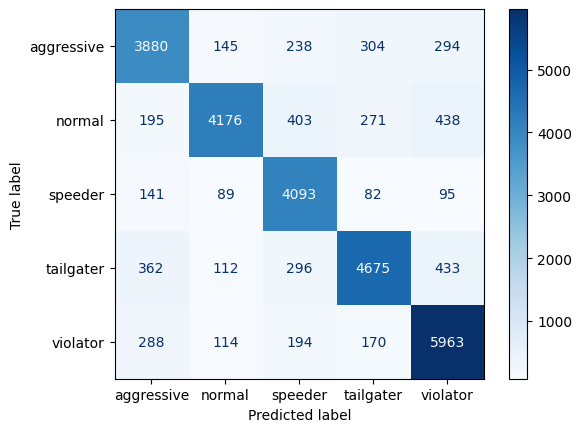

In [19]:
predictions = model_1.predict(X_test)
test_predict = np.argmax(predictions, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

precision = precision_score(y_test_labels, test_predict, average='macro')
recall = recall_score(y_test_labels, test_predict, average='macro')
f1 = f1_score(y_test_labels, test_predict, average='macro')
conf_matrix = confusion_matrix(y_test_labels, test_predict)
label_names = label_encoder.inverse_transform(sorted(set(y_test_labels)))

print('Precision:', round(precision,4))
print('Recall:', round(recall,4))
print('F1 Score:',round(f1,4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_names)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.grid(False)
plt.show()

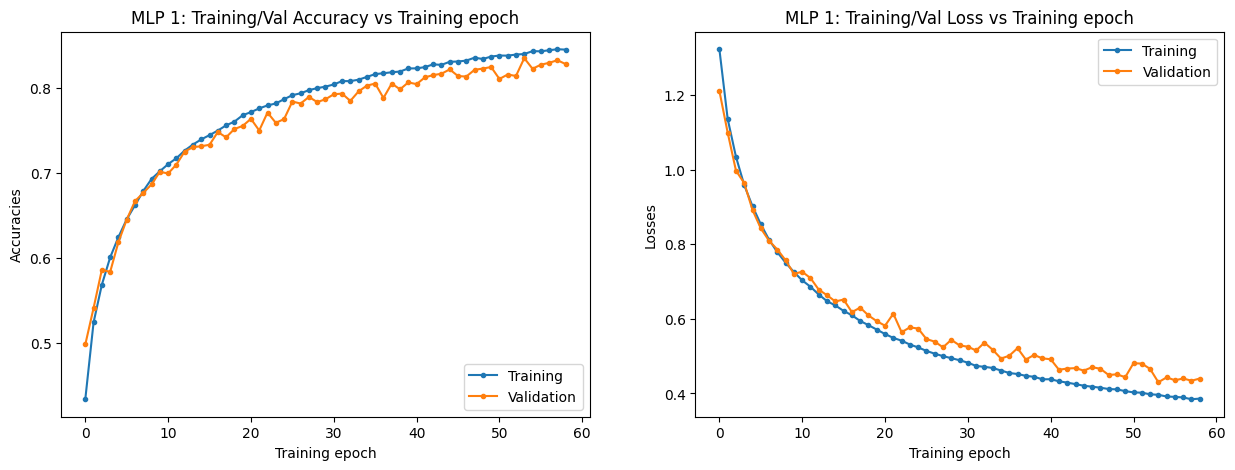

In [20]:
fig, ax = plt.subplots(1,2,figsize= (15,5))
ax[0].plot(modelx1.history["accuracy"],label = "Training",marker = '.')
ax[0].plot(modelx1.history["val_accuracy"],label = "Validation",marker = '.')
ax[0].set_title("MLP 1: Training/Val Accuracy vs Training epoch")
ax[0].set_xlabel("Training epoch")
ax[0].set_ylabel("Accuracies")
ax[1].plot(modelx1.history["loss"],label = "Training",marker = '.')
ax[1].plot(modelx1.history["val_loss"],label = "Validation",marker = '.')
ax[1].set_title("MLP 1: Training/Val Loss vs Training epoch")
ax[1].set_xlabel("Training epoch")
ax[1].set_ylabel("Losses")
ax[0].legend(loc="lower right")
ax[1].legend(loc="upper right");

### MLP-2 (Heavy-model)

In [26]:
model_2 = Sequential()
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dense(512, activation='relu'))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(y_train.shape[1], activation='softmax'))

model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2.build((1,X_train.shape[1]))
model_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (1, 128)                  8960      
                                                                 
 dense_39 (Dense)            (1, 512)                  66048     
                                                                 
 dense_40 (Dense)            (1, 256)                  131328    
                                                                 
 dropout_12 (Dropout)        (1, 256)                  0         
                                                                 
 dense_41 (Dense)            (1, 256)                  65792     
                                                                 
 dense_42 (Dense)            (1, 512)                  131584    
                                                                 
 dense_43 (Dense)            (1, 128)                 

In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5)
st = time.perf_counter()
modelx2 = model_2.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2,callbacks=[callback])
et = time.perf_counter()
t_time = et-st
loss, accuracy = model_2.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")
print(f"Training Time of MLP 2: {round(t_time,3)} sec")

Epoch 1/100
1373/1373 [==============================] - 54s 5ms/step - loss: 1.2028 - accuracy: 0.4811 - val_loss: 0.9888 - val_accuracy: 0.5769
Epoch 2/100
1373/1373 [==============================] - 8s 6ms/step - loss: 0.8960 - accuracy: 0.6158 - val_loss: 0.7715 - val_accuracy: 0.6696
Epoch 3/100
1373/1373 [==============================] - 8s 6ms/step - loss: 0.7264 - accuracy: 0.6862 - val_loss: 0.6316 - val_accuracy: 0.7295
Epoch 4/100
1373/1373 [==============================] - 8s 5ms/step - loss: 0.6200 - accuracy: 0.7322 - val_loss: 0.5647 - val_accuracy: 0.7531
Epoch 5/100
1373/1373 [==============================] - 8s 6ms/step - loss: 0.5514 - accuracy: 0.7630 - val_loss: 0.5061 - val_accuracy: 0.7810
Epoch 6/100
1373/1373 [==============================] - 7s 5ms/step - loss: 0.5011 - accuracy: 0.7837 - val_loss: 0.4753 - val_accuracy: 0.7976
Epoch 7/100
1373/1373 [==============================] - 8s 6ms/step - loss: 0.4670 - accuracy: 0.7983 - val_loss: 0.4334 - val_a

858/858 [==============================] - 2s 2ms/step
Precision: 0.9012
Recall: 0.8956
F1 Score: 0.8978


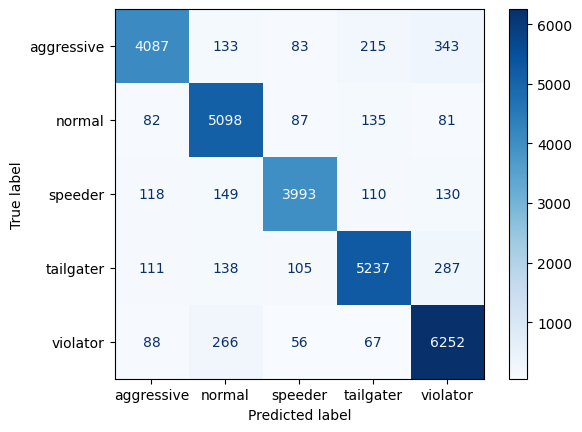

In [28]:
predictions = model_2.predict(X_test)
test_predict = np.argmax(predictions, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

precision = precision_score(y_test_labels, test_predict, average='macro')
recall = recall_score(y_test_labels, test_predict, average='macro')
f1 = f1_score(y_test_labels, test_predict, average='macro')
conf_matrix = confusion_matrix(y_test_labels, test_predict)
label_names = label_encoder.inverse_transform(sorted(set(y_test_labels)))

print('Precision:', round(precision,4))
print('Recall:', round(recall,4))
print('F1 Score:',round(f1,4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_names)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.grid(False)
plt.show()

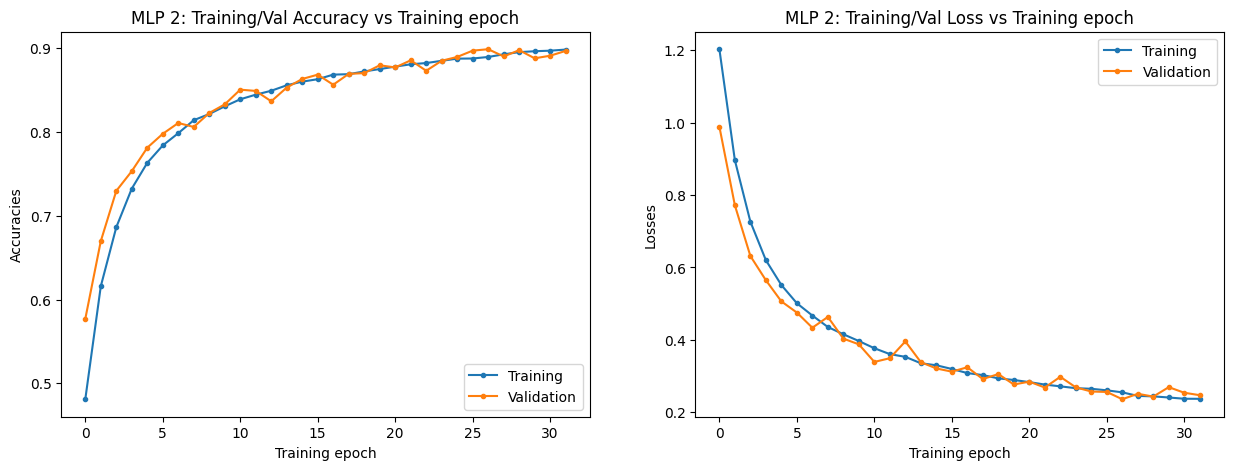

In [29]:
fig, ax = plt.subplots(1,2,figsize= (15,5))
ax[0].plot(modelx2.history["accuracy"],label = "Training",marker = '.')
ax[0].plot(modelx2.history["val_accuracy"],label = "Validation",marker = '.')
ax[0].set_title("MLP 2: Training/Val Accuracy vs Training epoch")
ax[0].set_xlabel("Training epoch")
ax[0].set_ylabel("Accuracies")
ax[1].plot(modelx2.history["loss"],label = "Training",marker = '.')
ax[1].plot(modelx2.history["val_loss"],label = "Validation",marker = '.')
ax[1].set_title("MLP 2: Training/Val Loss vs Training epoch")
ax[1].set_xlabel("Training epoch")
ax[1].set_ylabel("Losses")
ax[0].legend(loc="lower right")
ax[1].legend(loc="upper right");

### CNN Model

In [32]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 67, 128)           512       
                                                                 
 conv1d_9 (Conv1D)           (None, 65, 64)            24640     
                                                                 
 flatten_4 (Flatten)         (None, 4160)              0         
                                                                 
 dense_47 (Dense)            (None, 64)                266304    
                                                                 
 dense_48 (Dense)            (None, 5)                 325       
                                                                 
Total params: 291781 (1.11 MB)
Trainable params: 291781 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5)
st = time.perf_counter()
modelx3 = model_cnn.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,callbacks=[callback])
et = time.perf_counter()
t_time = et-st
loss, accuracy = model_cnn.evaluate(X_test, y_test)
print(f"CNN Model Test Loss: {loss}, Test Accuracy: {accuracy}")
print(f"Training Time of CNN: {round(t_time,3)} sec")

Epoch 1/100
2746/2746 [==============================] - 15s 5ms/step - loss: 1.2575 - accuracy: 0.4527 - val_loss: 1.1344 - val_accuracy: 0.5100
Epoch 2/100
2746/2746 [==============================] - 13s 5ms/step - loss: 1.0642 - accuracy: 0.5414 - val_loss: 1.0178 - val_accuracy: 0.5605
Epoch 3/100
2746/2746 [==============================] - 14s 5ms/step - loss: 0.9715 - accuracy: 0.5840 - val_loss: 0.9412 - val_accuracy: 0.6009
Epoch 4/100
2746/2746 [==============================] - 14s 5ms/step - loss: 0.9105 - accuracy: 0.6151 - val_loss: 0.8992 - val_accuracy: 0.6115
Epoch 5/100
2746/2746 [==============================] - 13s 5ms/step - loss: 0.8623 - accuracy: 0.6338 - val_loss: 0.8503 - val_accuracy: 0.6366
Epoch 6/100
2746/2746 [==============================] - 14s 5ms/step - loss: 0.8243 - accuracy: 0.6490 - val_loss: 0.8221 - val_accuracy: 0.6542
Epoch 7/100
2746/2746 [==============================] - 14s 5ms/step - loss: 0.7949 - accuracy: 0.6637 - val_loss: 0.7981 -

858/858 [==============================] - 2s 2ms/step
Precision: 0.7972
Recall: 0.8002
F1 Score: 0.7962


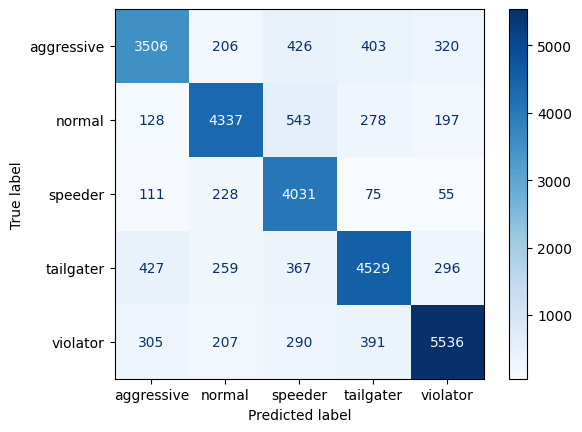

In [34]:
predictions = model_cnn.predict(X_test)
test_predict = np.argmax(predictions, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

precision = precision_score(y_test_labels, test_predict, average='macro')
recall = recall_score(y_test_labels, test_predict, average='macro')
f1 = f1_score(y_test_labels, test_predict, average='macro')
conf_matrix = confusion_matrix(y_test_labels, test_predict)
label_names = label_encoder.inverse_transform(sorted(set(y_test_labels)))

print('Precision:', round(precision,4))
print('Recall:', round(recall,4))
print('F1 Score:',round(f1,4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_names)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.grid(False)
plt.show()

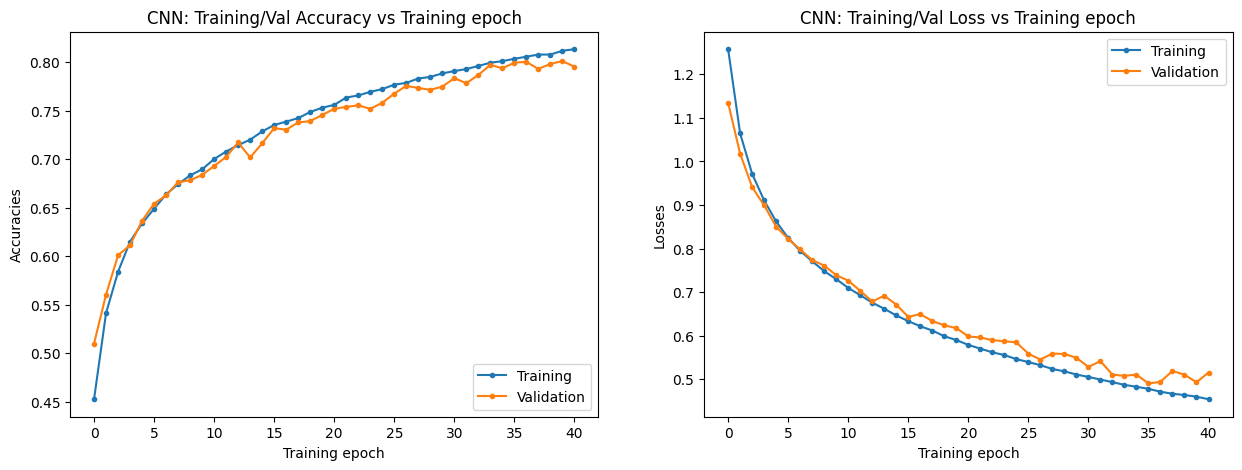

In [35]:
fig, ax = plt.subplots(1,2,figsize= (15,5))
ax[0].plot(modelx3.history["accuracy"],label = "Training",marker = '.')
ax[0].plot(modelx3.history["val_accuracy"],label = "Validation",marker = '.')
ax[0].set_title("CNN: Training/Val Accuracy vs Training epoch")
ax[0].set_xlabel("Training epoch")
ax[0].set_ylabel("Accuracies")
ax[1].plot(modelx3.history["loss"],label = "Training",marker = '.')
ax[1].plot(modelx3.history["val_loss"],label = "Validation",marker = '.')
ax[1].set_title("CNN: Training/Val Loss vs Training epoch")
ax[1].set_xlabel("Training epoch")
ax[1].set_ylabel("Losses")
ax[0].legend(loc="lower right")
ax[1].legend(loc="upper right");